In [1]:
import argparse, os, time
import pandas as pd
import geopandas as gpd
import polars as pl
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter, FuncFormatter
import matplotlib.patheffects as path_effects
from matplotlib.cm import get_cmap
from matplotlib.patches import Patch
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from collections import defaultdict
import warnings
from tqdm import tqdm
import pickle
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd


tqdm.pandas()
warnings.filterwarnings("ignore")

In [2]:
year = 16
pred_csv = f"./output/donors_state{year}_pred_lastname.csv"
donors_csv = f"./data/CampaignFin{year}/donors_recip{year}.csv"
cands_csv = f"./data/CampaignFin{year}/cands{year}.txt"
cmtes_csv = f"./data/CampaignFin{year}/cmtes{year}.txt"

In [3]:
donors = pd.read_csv(donors_csv)
donors.head(10)

,contrib_id,recip_id,name,name_new,realcode,gender,occupation,employer,city,state,total_donated,donation_count,avg_donation,med_donation
0,U00000036521,C00547349,"STEYER, THOMAS F",thomas f steyer,JE300,M,FOUNDER,"FAHR, LLC",SAN FRANCISCO,CA,89500000.0,14,6.392857e+06,6500000.0
1,,C00572958,PHILADELPHIA CONVENTION & VISITORS BUREAU FOUN...,philadelphia convention & visitors bureau foun...,Y4000,,NaN,NaN,PHILADELPHIA,PA,73299329.0,425,1.724690e+05,25000.0
2,,C00567057,AT&T,keycorp keycorp,Z9600,,NaN,NaN,CLEVELAND,OH,65268589.0,390,1.673554e+05,50000.0
3,,C00616078,STATWARE INC AND OTHER FIRMS,statware inc and other firms statware inc and ...,Z9600,,NaN,NaN,NEW YORK,CT,50325977.0,4,1.258149e+07,162738.5
4,,C00620971,AFSCME SPECIAL ACCOUNT,afscme special account afscme special account,Z9600,,NaN,NaN,WASHINGTON,DC,43280642.0,53,8.166159e+05,102021.0
5,,C00010603,NaN,,G6550,,NaN,NaN,PARK RIDGE,NY,42469722.0,106,4.006578e+05,20000.0
6,,C00495861,PRECISION NETWORK LLC,precision network llc precision network llc,Z9600,,NaN,NaN,WASHINGTON,DC,30985619.0,82,3.778734e+05,150000.0
7,,C00571372,CENTURY HOMEBUILDERS GROUP LLC,century homebuilders group llc century homebui...,Y4000,,NaN,NaN,TALLAHASSEE,FL,30552479.0,633,4.826616e+04,5000.0
8,,C00571703,ZUFFA LLC,zuffa llc zuffa llc,Z9600,,NaN,NaN,LAS VEGAS,NV,30111804.0,93,3.237828e+05,50000.0
9,,C00490730,REPUBLICAN GOVERNORS ASSOCIATION,republican governors association republican go...,Z5100,,NaN,NaN,WASHINGTON,DC,22732845.0,25,9.093138e+05,1000000.0


In [4]:
cands_lf = (
        pl.scan_csv(
            cands_csv,
            separator=',', 
            quote_char='|', 
            encoding='utf8-lossy', 
            has_header=False,
            new_columns=['dummy1', 'id', 'recip_id', 'name', 'party', 
                        'seat', 'seat_current', 'ran_general', 'ran_ever', 'type', 
                        'recipcode', 'nopacs'],
            ignore_errors=True
        )
        .select(['id', 'recip_id', 'name', 'party', 'seat', 'seat_current', 
                 'ran_general', 'ran_ever', 'type', 'recipcode'])
    )

cands = cands_lf.collect()
cands = cands.to_pandas()
cands = cands.drop_duplicates(subset=['recip_id', 'name', 'party', 'seat'], keep='last')
cands[(cands["seat"] == "PRES") & (cands["ran_general"] == "Y")]

,id,recip_id,name,party,seat,seat_current,ran_general,ran_ever,type,recipcode
4610,P20003984,N00033776,Jill Stein (3),3,PRES,,Y,Y,O,3L
6499,P60022654,N00040318,Evan McMullin (I),I,PRES,,Y,Y,O,3L
6607,P80001571,N00023864,Donald Trump (R),R,PRES,,Y,Y,O,RW


In [5]:
lf = (
        pl.scan_csv(
            cmtes_csv,
            separator=',', 
            quote_char='|', 
            encoding='utf8-lossy', 
            has_header=False,
            new_columns=['dummy1', 'cmte_id', 'pac_short', 'affiliate', 'pac', 
                        'recip_id', 'recipcode', 'cand_id', 'party', 'prim_code', 
                        'source', 'sensitive', 'foreign', 'active'],
            ignore_errors=True
        )
        .select(['cmte_id', 'pac_short', 'affiliate', 'pac',
                 'recip_id', 'recipcode', 'cand_id', 'party', 'prim_code',
                 'source', 'sensitive', 'foreign', 'active'])
    )
cmtes = lf.collect(streaming=True)
cmtes = cmtes.to_pandas()
cmtes[cmtes["party"] == "L"]

,cmte_id,pac_short,affiliate,pac,recip_id,recipcode,cand_id,party,prim_code,source,sensitive,foreign,active
1590,C00255695,Libertarian National Cmte,Libertarian Party,Libertarian Party,C00255695,3P,None,L,Z5300,Rept,N,0,1
1990,C00315713,Libertarian Party of Illinois,Libertarian Party,Libertarian Party,C00315713,3P,None,L,Z5300,Rept,N,0,1
2161,C00332221,Libertarian Assn of Massachusetts,None,Libertarian Assn of Massachusetts,C00332221,3P,None,L,Z5300,Rept,N,0,1
2185,C00334532,TUMA FOR CONGRESS ...,None,None,N00007582,3N,H8CA05134,L,Z1300,Rept,N,0,0
3136,C00399865,Libertarian Party of Virginia,Libertarian Party,Libertarian Party,C00399865,3P,None,L,Z5300,Rept,N,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15348,C00625376,STEVEN J. ISAACSON ...,None,None,N00040332,3L,H6AR03110,L,None,None,N,0,0
15371,C00625608,Committee to Elect Matt Wittlief for Congress,None,Committee to Elect Matt Wittlief for Congress,N00040337,3L,H6IN05257,L,Z1300,Rept,N,0,1
15450,C00626416,LIBERTARIAN PARTY OF SOUTH CENTRAL VIRGINIA ...,None,None,C00626416,None,None,L,None,None,None,0,0
15562,C00627539,GREG FAUST FOR CONGRESS ...,None,None,N00040509,3N,H8PA13091,L,None,None,N,0,0


In [6]:
mapping = {
    'A': 'Agribusiness',
    'B': 'Construction',
    'C': 'Tech',
    'D': 'Defense',
    'E': 'Energy',
    'F': 'Finance',
    'M': 'Misc Business',
    'H': 'Health',
    'J': 'Ideology/Single Issue',
    'K': 'Law',
    'L': 'Labor',
    'M': 'Manufacturing',
    'T': 'Transportation',
    'W': 'Other',
    'Y': 'Unknown',
    'Z': 'Party'
}

donors["sector"] = donors["realcode"].apply(lambda x: str(x).upper()[0]).map(mapping)
donors["sector"].value_counts()

sector
Unknown                  732936
Health                   383444
Finance                  365945
Ideology/Single Issue    280250
Law                      191744
Tech                     159916
Party                    107263
Labor                     96630
Energy                    84134
Construction              82836
Transportation            81422
Agribusiness              63335
Manufacturing             48741
Defense                   32944
Name: count, dtype: int64

In [7]:
preds = pd.read_csv(pred_csv)
donors = donors.merge(preds[['contrib_id', 'ethnic']], on='contrib_id', how='left')
donors = donors.merge(cands, on='recip_id', how='left')

In [8]:
donors = donors.merge(cmtes[
    ["cmte_id", "pac_short", "affiliate", "pac", "recip_id", "recipcode", "cand_id", "party"]], 
    left_on='recip_id', right_on="cmte_id", how='left', suffixes=[None, "_pac"]
    ).drop_duplicates(subset=['contrib_id', 'recip_id', 'cmte_id'], keep='last')

donors.loc[donors["pac"].notna(), "name_y"] = donors.loc[donors["pac"].notna(), "pac"]
donors.loc[donors["pac_short"].notna(), "name_y"] = donors.loc[donors["pac_short"].notna(), "pac_short"]

donors["recip_is_pac"] = False
donors.loc[donors["pac_short"].notna(), "recip_is_pac"] = True

donors.loc[donors["pac_short"].notna(), "party"] = donors.loc[donors["pac_short"].notna(), "party_pac"]

In [9]:
donors.loc[donors["name_y"] == "Stop Republicans PAC", "party"] = "D"
donors.loc[donors["name_y"] == "Senate Majority PAC", "party"] = "D"
donors.loc[donors["name_y"] == "314 Action Fund", "party"] = "D"
donors.loc[donors["name_y"] == "Progressive Takeover", "party"] = "D"
donors.loc[donors["name_y"] == "Black Americans to Re-Elect the President", "party"] = "R"
donors.loc[donors["name_y"] == "National Victory Action Fund", "party"] = "R"
donors.loc[donors["name_y"] == "MeidasTouch", "party"] = "D"
donors.loc[donors["name_y"] == "Swing Left", "party"] = "D"
donors.loc[donors["name_y"] == "Democratic Strategy Institute", "party"] = "D"
donors.loc[donors["name_y"] == "Senate Leadership Fund", "party"] = "R"
donors.loc[donors["name_y"] == "America First Action", "party"] = "R"
donors.loc[donors["name_y"] == "Future Forward USA", "party"] = "D"
donors.loc[donors["name_y"] == "Unite the Country", "party"] = "D"
donors.loc[donors["name_y"] == "Need to Impeach", "party"] = "D"
donors.loc[donors["name_y"] == "Tech for Campaigns", "party"] = "D"
donors.loc[donors["name_y"] == "Georgia Honor", "party"] = "D"
donors.loc[donors["name_y"] == "The Georgia Way", "party"] = "D"
donors.loc[donors["name_y"] == "Citizens for Free Enterprise", "party"] = "R"
donors.loc[donors["name_y"] == "Tom Steyer PAC", "party"] = "D"
donors.loc[donors["name_y"] == "GOPAC", "party"] = "R"
donors.loc[donors["name_y"] == "LMG PAC", "party"] = "D"
donors.loc[donors["name_y"] == "Democratic Majority for Israel", "party"] = "D"
donors.loc[donors["name_y"] == "Plains PAC", "party"] = "R"
donors.loc[donors["name_y"] == "Future Now Fund PAC", "party"] = "D"
donors.loc[donors["name_y"] == "House Freedom Action", "party"] = "R"
donors.loc[donors["name_y"] == "Way to Lead PAC", "party"] = "D"
donors.loc[donors["name_y"] == "Better Future Michigan Fund", "party"] = "R"
donors.loc[donors["name_y"] == "Digidems PAC", "party"] = "D"
donors.loc[donors["name_y"] == "Justice & Public Safety", "party"] = "D"
donors.loc[donors["name_y"] == "Casa in Action PAC", "party"] = "D"
donors.loc[donors["name_y"] == "Conservative Outsider PAC", "party"] = "R"
donors.loc[donors["name_y"] == "Save America Fund", "party"] = "D"
donors.loc[donors["name_y"] == "People Standing Strong", "party"] = "D"
donors.loc[donors["name_y"] == "State Government Citizens' Campaign", "party"] = "D"
donors.loc[donors["name_y"] == "Mind the Gap", "party"] = "D"
donors.loc[donors["name_y"] == "Elect Democratic Women", "party"] = "D"
donors.loc[donors["name_y"] == "Everyday People PAC", "party"] = "D"
donors.loc[donors["name_y"] == "For Our Families PAC", "party"] = "D"
donors.loc[donors["name_y"] == "Save the US Senate PAC", "party"] = "R"
donors.loc[donors["name_y"] == "One Vote at a Time", "party"] = "D"
donors.loc[donors["name_y"] == "Humanity Forward Fund", "party"] = "D"
donors.loc[donors["name_y"] == "One Vote at a Time", "party"] = "D"
donors.loc[donors["name_y"] == "American Patriots PAC", "party"] = "R"
donors.loc[donors["name_y"] == "Virginia Plus PAC", "party"] = "D"
donors.loc[donors["name_y"] == "Valor America", "party"] = "R"
donors.loc[donors["name_y"] == "United We Win", "party"] = "D"
donors.loc[donors["name_y"] == "New South Super PAC", "party"] = "D"
donors.loc[donors["name_y"] == "March On PAC", "party"] = "D"
donors.loc[donors["name_y"] == "L PAC", "party"] = "D"
donors.loc[donors["name_y"] == "Louisiana Legacy PAC", "party"] = "R"
donors.loc[donors["name_y"] == "Our Future United", "party"] = "D"
donors.loc[donors["name_y"] == "New American Jobs Fund", "party"] = "D"
donors.loc[donors["name_y"] == "Patriots of America PAC", "party"] = "R"
donors.loc[donors["name_y"] == "Sister District Project", "party"] = "D"
donors.loc[donors["name_y"] == "Abolitionists PAC", "party"] = "D"
donors.loc[donors["name_y"] == "California Democracy Ventures Fund", "party"] = "D"
donors.loc[donors["name_y"] == "WinRed", "party"] = "R"

In [10]:
donors.groupby(["name_y", "party"])["total_donated"].sum().sort_values(ascending=False)[:10]

name_y                                  party
Hillary Clinton (D)                     D        434582745.0
Hillary Victory Fund                    D        424379138.0
DNC Services Corp                       D        265169929.0
Republican National Cmte                R        188077819.0
Donald Trump (R)                        R        126558263.0
Trump Victory                           R        108025278.0
Bernie Sanders (I)                      D        106381630.0
Senate Leadership Fund                  R        104277254.0
Democratic Congressional Campaign Cmte  D         99435083.0
Democratic Senatorial Campaign Cmte     D         94388773.0
Name: total_donated, dtype: float64

In [11]:
contrib_party_totals = (
    donors.groupby(['contrib_id', 'name_new', 'party'])['total_donated']
    .sum()
    .unstack()
    .fillna(0)
)

contrib_party_totals['dem_ratio'] = (
    contrib_party_totals.get('D', 0) / 
    (contrib_party_totals.get('D', 0) + contrib_party_totals.get('R', 0))
)

donors = donors.merge(
    contrib_party_totals['dem_ratio'].reset_index(),
    on=['contrib_id', 'name_new'],
    how='left'
)

donors

,contrib_id,recip_id,name_x,name_new,realcode,gender,occupation,employer,city,state,...,cmte_id,pac_short,affiliate,pac,recip_id_pac,recipcode_pac,cand_id,party_pac,recip_is_pac,dem_ratio
0,U00000036521,C00547349,"STEYER, THOMAS F",thomas f steyer,JE300,M,FOUNDER,"FAHR, LLC",SAN FRANCISCO,CA,...,C00547349,NextGen Climate Action,NextGen Climate Action,NextGen Climate Action,C00547349,OI,None,None,True,1.0
1,,C00572958,PHILADELPHIA CONVENTION & VISITORS BUREAU FOUN...,philadelphia convention & visitors bureau foun...,Y4000,,NaN,NaN,PHILADELPHIA,PA,...,C00572958,Philadelphia 2016 Host Cmte,Democratic Party of Pennsylvania,Democratic Party of Pennsylvania,C00572958,DP,None,D,True,1.0
2,,C00567057,AT&T,keycorp keycorp,Z9600,,NaN,NaN,CLEVELAND,OH,...,C00567057,Cleveland 2016 Host Cmte,None,Cleveland 2016 Host Cmte,C00567057,RP,None,R,True,0.0
3,,C00616078,STATWARE INC AND OTHER FIRMS,statware inc and other firms statware inc and ...,Z9600,,NaN,NaN,NEW YORK,CT,...,C00616078,Get Our Jobs Back,None,Get Our Jobs Back,C00616078,OI,None,None,True,NaN
4,,C00620971,AFSCME SPECIAL ACCOUNT,afscme special account afscme special account,Z9600,,NaN,NaN,WASHINGTON,DC,...,C00620971,For Our Future,None,For Our Future,C00620971,OL,None,,True,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3883245,p0005231805,C00019331,"SAVALL, MARY L",mary l savall,Y2000,F,INFORMATION REQUESTED,INFORMATION REQUESTED,MADISON,WI,...,C00019331,Democratic Party of Wisconsin,Democratic Party of Wisconsin,Democratic Party of Wisconsin,C00019331,DP,None,D,True,1.0
3883246,p0004434714,N00023864,"BROWN, JACK W MR JR",jack w mr jr brown,X1200,M,RETIRED,RETIRED,EL PASO,TX,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.0
3883247,j1001178767,N00004357,"PRICE, JOAN",joan price,Y4000,F,BUSINESS FINANCE,CUSTOM INSTALLERS,WINDSOR,CO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.0
3883248,m0001741643,N00004357,"SMITH, CECIL",cecil smith,Y2000,M,INFORMATION REQUESTED PER BEST EFFORTS,INFORMATION REQUESTED PER BEST EFFORTS,SODDY DAISY,TN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.0


In [12]:
donors[~(donors["name_y"].isna())].sort_values(by=['total_donated'], ascending=False).iloc[:10][["name_new", "realcode", "gender", "occupation", "city", "state", "total_donated", "name_y", "party", "seat", "type", "recipcode"]]

,name_new,realcode,gender,occupation,city,state,total_donated,name_y,party,seat,type,recipcode
0,thomas f steyer,JE300,M,FOUNDER,SAN FRANCISCO,CA,89500000.0,NextGen Climate Action,None,NaN,NaN,NaN
1,philadelphia convention & visitors bureau foun...,Y4000,,NaN,PHILADELPHIA,PA,73299329.0,Philadelphia 2016 Host Cmte,D,NaN,NaN,NaN
2,keycorp keycorp,Z9600,,NaN,CLEVELAND,OH,65268589.0,Cleveland 2016 Host Cmte,R,NaN,NaN,NaN
3,statware inc and other firms statware inc and ...,Z9600,,NaN,NEW YORK,CT,50325977.0,Get Our Jobs Back,None,NaN,NaN,NaN
4,afscme special account afscme special account,Z9600,,NaN,WASHINGTON,DC,43280642.0,For Our Future,,NaN,NaN,NaN
5,,G6550,,NaN,PARK RIDGE,NY,42469722.0,DNC Services Corp,D,NaN,NaN,NaN
6,precision network llc precision network llc,Z9600,,NaN,WASHINGTON,DC,30985619.0,Priorities USA Action,None,NaN,NaN,NaN
7,century homebuilders group llc century homebui...,Y4000,,NaN,TALLAHASSEE,FL,30552479.0,Right To Rise USA,None,NaN,NaN,NaN
8,zuffa llc zuffa llc,Z9600,,NaN,LAS VEGAS,NV,30111804.0,Senate Leadership Fund,R,NaN,NaN,NaN
9,republican governors association republican go...,Z5100,,NaN,WASHINGTON,DC,22732845.0,RGA Right Direction,None,NaN,NaN,NaN


In [13]:
donors[~(donors["name_y"].isna()) & (donors["ethnic"] == "ind")].sort_values(by=['total_donated'], ascending=False).iloc[:10][["contrib_id", "name_new", "realcode", "gender", "occupation", "city", "state", "total_donated", "name_y", "party", "seat", "type", "recipcode"]]

,contrib_id,name_new,realcode,gender,occupation,city,state,total_donated,name_y,party,seat,type,recipcode
284,U0000004554,vivek garipalli,H2100,M,EXECUTIVE,WILMINGTON,DE,1000000.0,Coalition For Progress,,NaN,NaN,NaN
457,U00000035581,muneer a mr satter,F2600,M,PRIVATE INVESTOR,CHICAGO,IL,550000.0,Right To Rise USA,None,NaN,NaN,NaN
483,h3003459110,rishi u shah,H3900,M,CEO,CHICAGO,IL,522500.0,Hillary Victory Fund,D,NaN,NaN,NaN
484,j10021390841,shalabh kumar,C5400,U,CHAIRMAN/CEO,KILDEER,IL,522000.0,Trump Victory,R,NaN,NaN,NaN
603,j1002139084A,shama kumar,C5400,F,HOMEMAKER,KILDEER,IL,472000.0,Trump Victory,R,NaN,NaN,NaN
625,U00000003781,amy rao,C5130,F,CEO,PALO ALTO,CA,466400.0,Hillary Victory Fund,D,NaN,NaN,NaN
702,h30013924601,shashikant gupta,G5270,M,CEO,RESTON,VA,423800.0,Hillary Victory Fund,D,NaN,NaN,NaN
703,h3001392460@,margaret gupta,G5270,F,COO,RESTON,VA,423800.0,Hillary Victory Fund,D,NaN,NaN,NaN
962,U00000035581,muneer a satter,F2600,M,PRIVATE INVESTOR,CHICAGO,IL,333800.0,Team Ryan,R,NaN,NaN,NaN
971,U00000035581,muneer a mr satter,F2600,M,RETIRED,CHICAGO,IL,328800.0,National Republican Congressional Cmte,R,NaN,NaN,NaN


In [14]:
donors[~(donors["name_y"].isna())].drop_duplicates(subset=['recip_id', 'name_y', 'party'], keep='last')['party'].value_counts()

party
R    1666
D    1361
      914
3      75
I      69
L      61
U       4
r       1
Name: count, dtype: int64

In [15]:
donors[~(donors["name_y"].isna()) & (donors["ethnic"] == "ind")].drop_duplicates(subset=['recip_id', 'name_y', 'party'], keep='last')['party'].value_counts()

party
D    553
R    496
      71
3      5
I      5
L      4
Name: count, dtype: int64

In [16]:
donors[~(donors["name_y"].isna()) & (donors["ethnic"] == "ind")].drop_duplicates(subset=['recip_id', 'name_y', 'party'], keep='last')[["recip_id", "name_y", "party", "seat"]]

,recip_id,name_y,party,seat
2060,C00504530,Congressional Leadership Fund,None,NaN
6263,C00605717,Ryan-McCarthy Victory,R,NaN
7455,C00528034,Louisiana Prosperity Fund,None,NaN
16910,C00622506,Patriotic Artists & Creatives,,NaN
18316,C00573055,America Leads,,NaN
...,...,...,...,...
3877970,N00000528,Bernie Sanders (I),D,VTS1
3880051,N00000019,Hillary Clinton (D),D,PRES
3882094,N00023864,Donald Trump (R),R,PRES
3882941,C00003418,Republican National Cmte,R,NaN


In [17]:
donors[~(donors["name_y"].isna()) & (donors["ethnic"] == "ind") & (donors["state"] == "WY")].sort_values(by=['total_donated'], ascending=False).iloc[:10][["contrib_id", "name_new", "realcode", "gender", "occupation", "city", "state", "total_donated", "name_y", "party", "seat", "type", "recipcode"]]

,contrib_id,name_new,realcode,gender,occupation,city,state,total_donated,name_y,party,seat,type,recipcode
17750,p0001273346,king f husein,Y4000,U,ENGINEER,JACKSON,WY,25000.0,Team Ryan,R,NaN,NaN,NaN
23309,p0001273346,king f husein,Y4000,U,ENGINEER,JACKSON,WY,19600.0,National Republican Congressional Cmte,R,NaN,NaN,NaN
121669,p0001273346,king f husein,Y4000,U,ENGINEER,JACKSON,WY,5400.0,Paul Ryan (R),R,WI01,I,RW
314068,i3003307686,neil mr patel,C1100,M,CO-FOUNDER AND PUBLISHER,WILSON,WY,2700.0,Liz Cheney (R),R,WY01,O,RW
391479,m0001428802@,diane mrs husein,Y4000,F,VICE PRESIDENT,JACKSON,WY,2700.0,Liz Cheney (R),R,WY01,O,RW
391783,m00014288021,king mr husein,B1500,M,CHAIRMAN AND CEO,JACKSON,WY,2700.0,Liz Cheney (R),R,WY01,O,RW
746274,p0003952834,rathna raju,H1100,U,PHYSICIAN,WILSON,WY,1221.0,Bernie Sanders (I),D,VTS1,I,3I
772096,p0001413164,kevin j reddy,L1400,M,FIRE FIGHTER / EMS,CHEYENNE,WY,1134.0,International Assn of Fire Fighters,None,NaN,NaN,NaN
778257,j1002220503,manmohan patel,T9100,M,HOTEL MANAGEMENT,LARAMIE,WY,1104.0,Asian American Hotel Owners Assn,None,NaN,NaN,NaN
935399,m00014288021,king husein,B1500,M,ENGINEER,JACKSON,WY,1000.0,David Rogers (R),R,CA16,C,RL


In [18]:
# 2020: 5.8 billion vs 38.5 million
print("Overall:", donors[~(donors["name_y"].isna())]["total_donated"].sum())
print("Indians:", donors[~(donors["name_y"].isna()) & (donors["ethnic"] == "ind")]["total_donated"].sum())

Overall: 6741885615.0
Indians: 47901983.0


In [19]:
print("Finance:", donors[(donors["sector"] == "Finance") & ~(donors["name_y"].isna())]["total_donated"].sum())
print("Finance, Indian:", donors[(donors["sector"] == "Finance") & ~(donors["name_y"].isna()) & (donors["ethnic"] == "ind")]["total_donated"].sum())
print("Tech:", donors[(donors["sector"] == "Tech") & ~(donors["name_y"].isna())]["total_donated"].sum())
print("Tech, Indian:", donors[(donors["sector"] == "Tech") & ~(donors["name_y"].isna()) & (donors["ethnic"] == "ind")]["total_donated"].sum())
print("Health:", donors[(donors["sector"] == "Health") & ~(donors["name_y"].isna())]["total_donated"].sum())
print("Healthm Indian:", donors[(donors["sector"] == "Health") & ~(donors["name_y"].isna()) & (donors["ethnic"] == "ind")]["total_donated"].sum())

Finance: 1375478978.0
Finance, Indian: 8370754.0
Tech: 412412392.0
Tech, Indian: 6023008.0
Health: 477688370.0
Healthm Indian: 10499614.0


In [20]:
donors["seat"].value_counts()

seat
PRES    1017964
VTS1     239951
TXS2      88496
FLS2      54684
WIS2      33233
         ...   
MP00         47
IDS1         43
TNS2         42
WVS2         18
SC00          3
Name: count, Length: 543, dtype: int64

In [23]:
donors["level"] = donors["seat"].apply(lambda x: "Senate" if "S1" in str(x) or "S2" in str(x) else "President" if str(x) == "PRES" else "House" if type(x) == str and len(str(x)) == 4 else "Unknown")
donors["level"] = donors.apply(lambda x: "PAC" if x["level"] == "Unknown" and x["recip_is_pac"] == True else x["level"], axis=1)
donors["level"].value_counts()

level
PAC          1650578
President    1017964
Senate        751573
House         455120
Unknown         8015
Name: count, dtype: int64

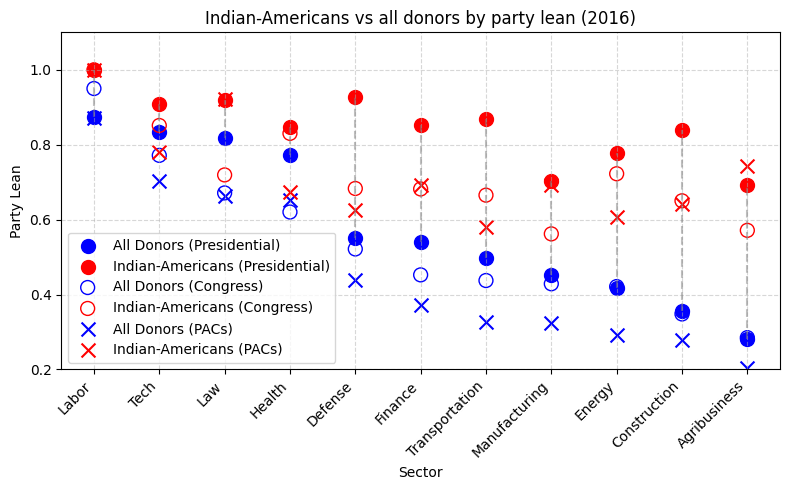

In [29]:
mean_all_pres = donors.drop_duplicates(subset=["contrib_id", "dem_ratio"])[(~donors["sector"].isin(["Ideology/Single Issue", "Unknown", "Party"])) & (donors["level"] == "President")].groupby("sector")["dem_ratio"].mean().sort_values(ascending=False)
mean_ind_pres = donors.drop_duplicates(subset=["contrib_id", "dem_ratio"])[(~donors["sector"].isin(["Ideology/Single Issue", "Unknown", "Party"])) & (donors["level"] == "President")][donors["ethnic"].str.contains("ind", na=False)].groupby("sector")["dem_ratio"].mean().sort_values(ascending=False)
sectors = mean_all_pres.index
mean_ind_pres = mean_ind_pres.reindex(sectors, fill_value=0)

mean_all = donors.drop_duplicates(subset=["contrib_id", "dem_ratio"])[(~donors["sector"].isin(["Ideology/Single Issue", "Unknown", "Party"])) & (donors["level"].isin(["Senate", "House"]))].groupby("sector")["dem_ratio"].mean().sort_values(ascending=False)
mean_ind = donors.drop_duplicates(subset=["contrib_id", "dem_ratio"])[(~donors["sector"].isin(["Ideology/Single Issue", "Unknown", "Party"])) & (donors["level"].isin(["Senate", "House"]))][donors["ethnic"].str.contains("ind", na=False)].groupby("sector")["dem_ratio"].mean().sort_values(ascending=False)
sectors = mean_all.index
mean_ind = mean_ind.reindex(sectors, fill_value=0)

mean_all_pac = donors.drop_duplicates(subset=["contrib_id", "dem_ratio"])[(~donors["sector"].isin(["Ideology/Single Issue", "Unknown", "Party"])) & (donors["level"] == "PAC")].groupby("sector")["dem_ratio"].mean().sort_values(ascending=False)
mean_ind_pac = donors.drop_duplicates(subset=["contrib_id", "dem_ratio"])[(~donors["sector"].isin(["Ideology/Single Issue", "Unknown", "Party"])) & (donors["level"] == "PAC")][donors["ethnic"].str.contains("ind", na=False)].groupby("sector")["dem_ratio"].mean().sort_values(ascending=False)
sectors = mean_all_pac.index
mean_ind_pac = mean_ind_pac.reindex(sectors, fill_value=0)

plt.figure(figsize=(8, 5))

for cat, g1, g2 in zip(sectors, mean_all_pres, mean_ind_pres):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)

plt.scatter(sectors, mean_all_pres, color='blue', label='All Donors (Presidential)', s=100)
plt.scatter(sectors, mean_ind_pres, color='red', label='Indian-Americans (Presidential)', s=100)
plt.scatter(sectors, mean_all, facecolors='none', edgecolors='blue', label='All Donors (Congress)', s=100)
plt.scatter(sectors, mean_ind, facecolors='none', edgecolors='red', label='Indian-Americans (Congress)', s=100)
plt.scatter(sectors, mean_all_pac, marker="x", color='blue', label='All Donors (PACs)', s=100)
plt.scatter(sectors, mean_ind_pac, marker="x", color='red', label='Indian-Americans (PACs)', s=100)

plt.title(f"Indian-Americans vs all donors by party lean (20{year})")
plt.xlabel("Sector")
plt.ylabel("Party Lean")
plt.ylim([0.2, 1.1])
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

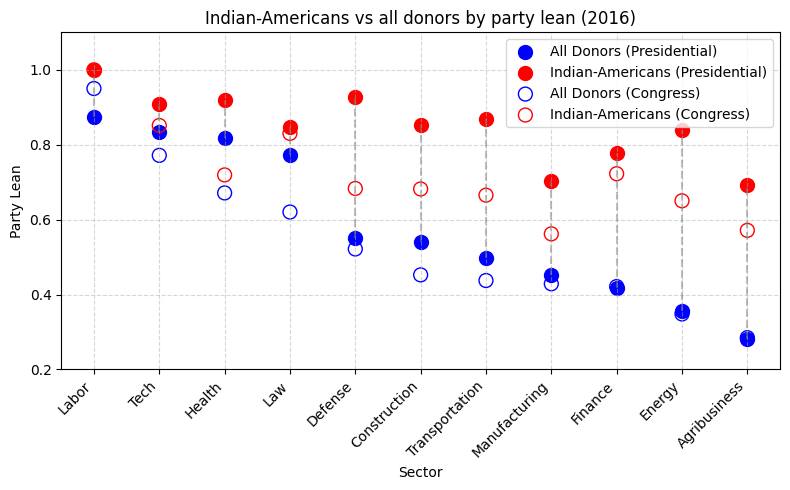

In [30]:
mean_all_pres = donors.drop_duplicates(subset=["contrib_id", "dem_ratio"])[(~donors["sector"].isin(["Ideology/Single Issue", "Unknown", "Party"])) & (donors["level"] == "President")].groupby("sector")["dem_ratio"].mean().sort_values(ascending=False)
mean_ind_pres = donors.drop_duplicates(subset=["contrib_id", "dem_ratio"])[(~donors["sector"].isin(["Ideology/Single Issue", "Unknown", "Party"])) & (donors["level"] == "President")][donors["ethnic"].str.contains("ind", na=False)].groupby("sector")["dem_ratio"].mean().sort_values(ascending=False)
sectors = mean_all_pres.index
mean_ind_pres = mean_ind_pres.reindex(sectors, fill_value=0)

mean_all = donors.drop_duplicates(subset=["contrib_id", "dem_ratio"])[(~donors["sector"].isin(["Ideology/Single Issue", "Unknown", "Party"])) & (donors["level"].isin(["Senate", "House"]))].groupby("sector")["dem_ratio"].mean().sort_values(ascending=False)
mean_ind = donors.drop_duplicates(subset=["contrib_id", "dem_ratio"])[(~donors["sector"].isin(["Ideology/Single Issue", "Unknown", "Party"])) & (donors["level"].isin(["Senate", "House"]))][donors["ethnic"].str.contains("ind", na=False)].groupby("sector")["dem_ratio"].mean().sort_values(ascending=False)
sectors = mean_all.index
mean_ind = mean_ind.reindex(sectors, fill_value=0)

plt.figure(figsize=(8, 5))

for cat, g1, g2 in zip(sectors, mean_all_pres, mean_ind_pres):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)

plt.scatter(sectors, mean_all_pres, color='blue', label='All Donors (Presidential)', s=100)
plt.scatter(sectors, mean_ind_pres, color='red', label='Indian-Americans (Presidential)', s=100)
plt.scatter(sectors, mean_all, facecolors='none', edgecolors='blue', label='All Donors (Congress)', s=100)
plt.scatter(sectors, mean_ind, facecolors='none', edgecolors='red', label='Indian-Americans (Congress)', s=100)

plt.title(f"Indian-Americans vs all donors by party lean (20{year})")
plt.xlabel("Sector")
plt.ylabel("Party Lean")
plt.ylim([0.2, 1.1])
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

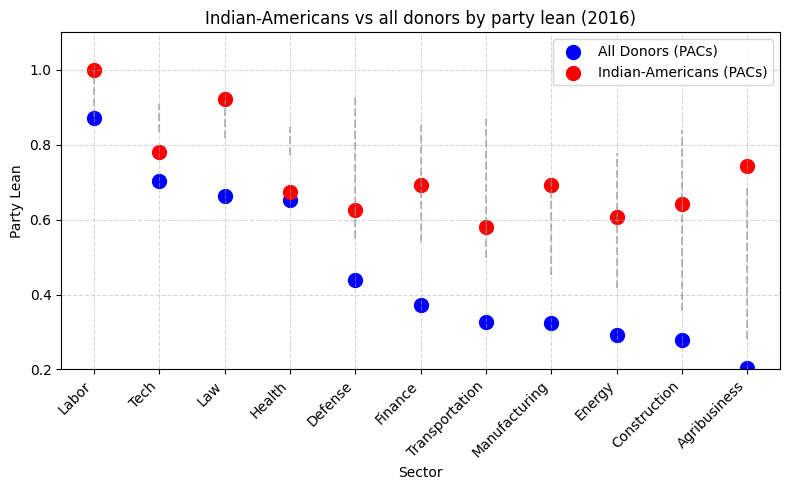

In [31]:
mean_all_pac = donors.drop_duplicates(subset=["contrib_id", "dem_ratio"])[(~donors["sector"].isin(["Ideology/Single Issue", "Unknown", "Party"])) & (donors["level"] == "PAC")].groupby("sector")["dem_ratio"].mean().sort_values(ascending=False)
mean_ind_pac = donors.drop_duplicates(subset=["contrib_id", "dem_ratio"])[(~donors["sector"].isin(["Ideology/Single Issue", "Unknown", "Party"])) & (donors["level"] == "PAC")][donors["ethnic"].str.contains("ind", na=False)].groupby("sector")["dem_ratio"].mean().sort_values(ascending=False)
sectors = mean_all_pac.index
mean_ind_pac = mean_ind_pac.reindex(sectors, fill_value=0)

plt.figure(figsize=(8, 5))

for cat, g1, g2 in zip(sectors, mean_all_pres, mean_ind_pres):
    plt.plot([cat, cat], [g1, g2], color='gray', linestyle='--', alpha=0.5)

plt.scatter(sectors, mean_all_pac, color='blue', label='All Donors (PACs)', s=100)
plt.scatter(sectors, mean_ind_pac, color='red', label='Indian-Americans (PACs)', s=100)

plt.title(f"Indian-Americans vs all donors by party lean (20{year})")
plt.xlabel("Sector")
plt.ylabel("Party Lean")
plt.ylim([0.2, 1.1])
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [32]:
pd.DataFrame(mean_all_pres).merge(pd.DataFrame(mean_ind_pres), left_index=True, right_index=True, suffixes=('_all_pres', '_ind_pres')).reset_index().rename(columns={'index': 'sector'})

,sector,dem_ratio_all_pres,dem_ratio_ind_pres
0,Labor,0.874830,1.000000
1,Tech,0.834259,0.908497
2,Law,0.818791,0.920526
3,Health,0.773121,0.846560
4,Defense,0.552252,0.928571
5,Finance,0.540544,0.852233
6,Manufacturing,0.496510,0.869281
7,Transportation,0.450928,0.702290
8,Energy,0.416561,0.777778
9,Construction,0.355878,0.840128


In [33]:
pd.DataFrame(mean_all).merge(pd.DataFrame(mean_ind), left_index=True, right_index=True, suffixes=('_all_cong', '_ind_cong')).reset_index().rename(columns={'index': 'sector'})

,sector,dem_ratio_all_cong,dem_ratio_ind_cong
0,Labor,0.949986,1.000000
1,Tech,0.771591,0.851338
2,Health,0.671293,0.719374
3,Law,0.620364,0.830296
4,Defense,0.521729,0.683179
5,Construction,0.452561,0.681866
6,Transportation,0.437500,0.665359
7,Manufacturing,0.428806,0.562019
8,Finance,0.421331,0.722518
9,Energy,0.348231,0.650305


In [34]:
pd.DataFrame(mean_all_pac).merge(pd.DataFrame(mean_ind_pac), left_index=True, right_index=True, suffixes=('_all_pac', '_ind_pac')).reset_index().rename(columns={'index': 'sector'})

,sector,dem_ratio_all_pac,dem_ratio_ind_pac
0,Labor,0.871305,1.000000
1,Tech,0.704265,0.779968
2,Law,0.663466,0.921678
3,Health,0.653148,0.674479
4,Defense,0.438589,0.625000
5,Finance,0.372779,0.692104
6,Transportation,0.327283,0.580736
7,Manufacturing,0.325005,0.692997
8,Energy,0.292390,0.607143
9,Construction,0.277849,0.640746


In [35]:
print("Overall, presidential: ", mean_all_pres.mean())
print("Indians, presidential: ", mean_ind_pres.mean())
print("Overall, congressional: ", mean_all.mean())
print("Indians, congressional: ", mean_ind.mean())
print("Overall, PAC: ", mean_all_pac.mean())
print("Indians, PAC: ", mean_ind_pac.mean())

Overall, presidential:  0.5814895488586096
Indians, presidential:  0.848924666314169
Overall, congressional:  0.5371302443438156
Indians, congressional:  0.7216075266025356
Overall, PAC:  0.46641464709902875
Indians, PAC:  0.723494640376108


In [36]:
state_stats = (
    donors.groupby(["state", "party", "level"])
    .agg(
        avg_amount=("total_donated", "mean"),
        med_amount=("total_donated", "median"),
        total_donations=("total_donated", "sum"),
        donor_count=("total_donated", "count"),
        avg_amount_indian=("total_donated", lambda x: x[donors.loc[x.index, "ethnic"] == "ind"].mean()),
        med_amount_indian=("total_donated", lambda x: x[donors.loc[x.index, "ethnic"] == "ind"].median()),
        total_donations_indian=("total_donated", lambda x: x[donors.loc[x.index, "ethnic"] == "ind"].sum()),
        donor_count_indian=("ethnic", lambda x: (x == "ind").sum())
    )
    .sort_values("total_donations", ascending=False)
    .reset_index()
)
state_stats.head(10)

,state,party,level,avg_amount,med_amount,total_donations,donor_count,avg_amount_indian,med_amount_indian,total_donations_indian,donor_count_indian
0,NY,D,PAC,4663.495307,500.0,302110553.0,64782,4030.798425,1000.0,2559557.0,635
1,CA,D,PAC,2819.763671,456.0,299230501.0,106119,4994.621993,500.0,4360305.0,873
2,DC,,PAC,161947.833333,500.0,117574127.0,726,5249.200000,301.0,26246.0,5
3,TX,R,PAC,2479.921184,400.0,110976473.0,44750,2075.577320,500.0,201331.0,97
4,CA,R,PAC,2231.752112,301.0,110962715.0,49720,2468.385417,487.5,473930.0,192
5,PA,D,PAC,5860.151815,325.5,101404067.0,17304,733.354167,263.0,70402.0,96
6,CA,D,President,957.504464,355.0,99946231.0,104382,1179.140167,500.0,1127258.0,956
7,OH,R,PAC,6605.081185,404.0,96084116.0,14547,1732.704545,500.0,76239.0,44
8,NV,R,PAC,16512.903341,400.0,92422720.0,5597,6555.500000,920.0,52444.0,8
9,NY,R,PAC,4710.171937,450.0,86539989.0,18373,1216.204301,328.0,113107.0,93


In [37]:
# Load U.S. states geometry (Natural Earth dataset)
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_1_states_provinces.zip"
gdf = gpd.read_file(url)

exclude_codes = ["US-AK", "US-HI", "US-PR", "US-GU", "US-VI", "US-AS", "US-MP"]
gdf = gdf[(gdf["iso_a2"] == "US") & (~gdf["iso_3166_2"].isin(exclude_codes))][["iso_3166_2", "name", "geometry"]]
gdf["state"] = gdf["iso_3166_2"].str.replace("US-", "")
gdf_merged = gdf.merge(state_stats, on="state", how="left")

In [38]:
population = pd.read_csv("./data/aapi_population.csv", sep="\t")
population.head(10)

,Year,Name,Code,Indian Pop,Census Pop,Share
0,2020,Alabama,AL,14673,5033094,0.291530
1,2020,Alaska,AK,0,733017,0.000000
2,2020,Arizona,AZ,62246,7187135,0.866075
3,2020,Arkansas,AR,12461,3014546,0.413362
4,2020,California,CA,856180,39521958,2.166340
5,2020,Colorado,CO,33486,5787129,0.578629
6,2020,Connecticut,CT,61888,3579918,1.728755
7,2020,Delaware,DE,16076,991928,1.620682
8,2020,District of Columbia,DC,176769,670917,26.347372
9,2020,Florida,FL,181805,21592035,0.842000


In [39]:
gdf_merged = gdf_merged.merge(population, left_on="state", right_on="Code", how="left")

In [40]:
state_pivot = state_stats.pivot(index=['state', 'level'], columns='party', values='total_donations').fillna(0)
state_pivot['total'] = state_pivot['D'] + state_pivot['R']
state_pivot['dem_ratio'] = state_pivot['D'] / state_pivot['total']

state_pivot_indian = state_stats.pivot(index=['state', 'level'], columns='party', values='total_donations_indian').fillna(0)
state_pivot_indian['total'] = state_pivot_indian['D'] + state_pivot_indian['R']
state_pivot_indian['dem_ratio'] = state_pivot_indian['D'] / state_pivot_indian['total']

ratio = gdf.merge(state_pivot.reset_index(), left_on=['state'], right_on=['state'], how='right')
ratio_indian = gdf.merge(state_pivot_indian.reset_index(), left_on=['state'], right_on=['state'], how='right')

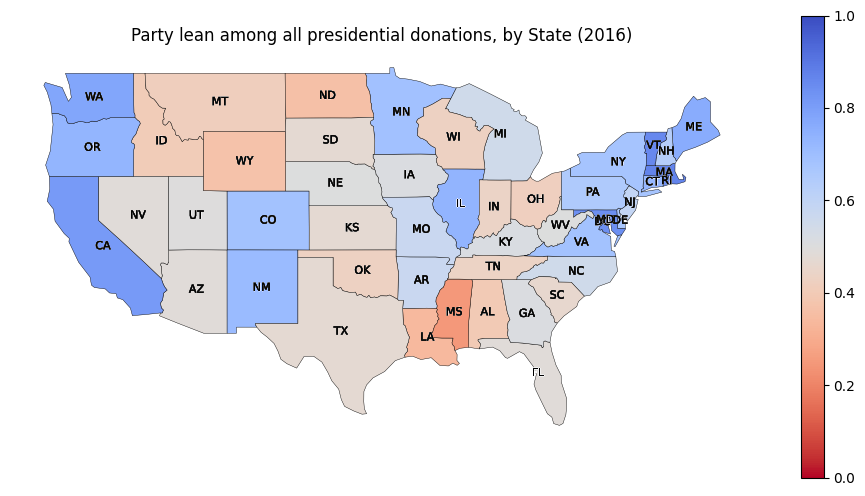

In [41]:
fig, ax = plt.subplots(figsize=(12, 6))
ratio[ratio["level"] == "President"].plot(
    column="dem_ratio",
    cmap="coolwarm_r",
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    legend=True,
    missing_kwds={"color": "lightgray"},
    vmin=0,
    vmax=1
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="black")
    text.set_path_effects([path_effects.Stroke(linewidth=0.1, foreground="white"), path_effects.Normal()])

ax.set_title(f'Party lean among all presidential donations, by State (20{year})')
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [42]:
ratio[ratio["level"] == "President"][["state", "total"]].sort_values(by="total", ascending=False).head(10)

,state,total
50,CA,123317202.0
197,NY,97113453.0
245,TX,47011476.0
74,FL,44432165.0
130,MA,24436507.0
255,VA,23379009.0
105,IL,21865074.0
134,MD,20981028.0
183,NJ,20604505.0
216,PA,19362781.0


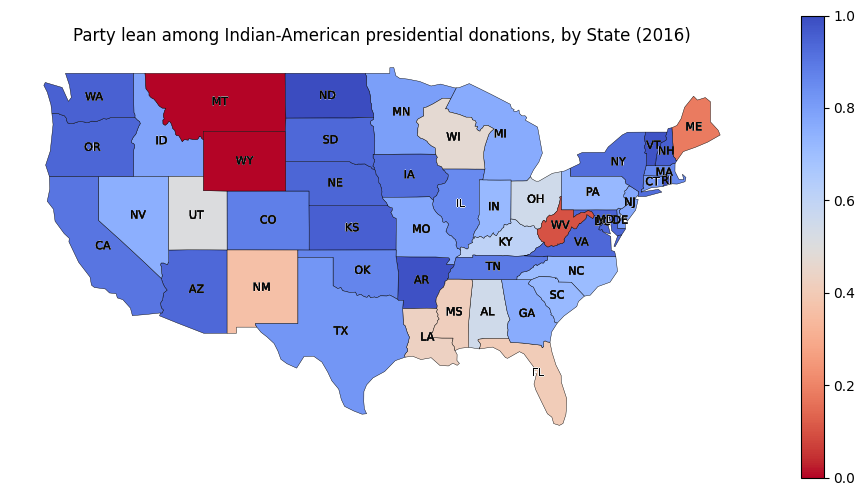

In [43]:
fig, ax = plt.subplots(figsize=(12, 6))
ratio_indian[ratio_indian["level"] == "President"].plot(
    column="dem_ratio",
    cmap="coolwarm_r",
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    legend=True,
    missing_kwds={"color": "lightgray"},
    vmin=0,
    vmax=1
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="black")
    text.set_path_effects([path_effects.Stroke(linewidth=0.1, foreground="white"), path_effects.Normal()])

ax.set_title(f'Party lean among Indian-American presidential donations, by State (20{year})')
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [44]:
ratio_indian[ratio_indian["level"] == "President"][["state", "total"]].sort_values(by="total", ascending=False).head(10)

,state,total
50,CA,1249159.0
197,NY,798453.0
245,TX,483082.0
183,NJ,341485.0
255,VA,321854.0
74,FL,310637.0
105,IL,299933.0
134,MD,277328.0
130,MA,186991.0
63,DC,164643.0


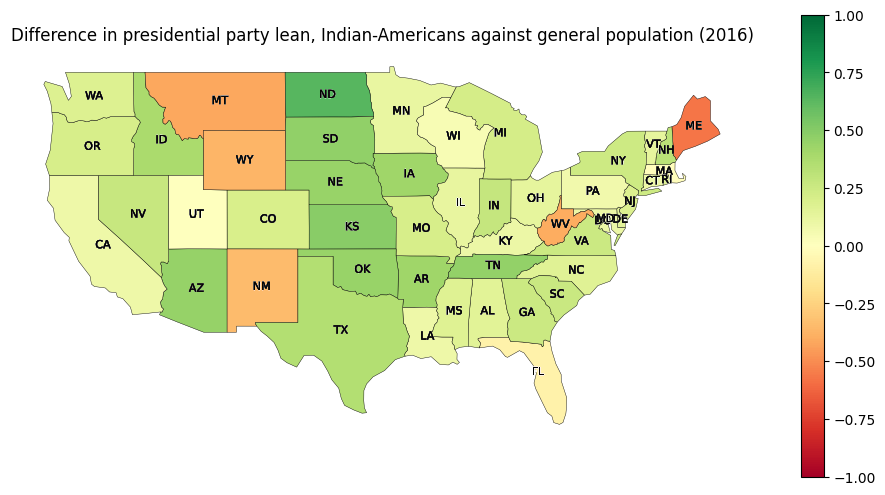

In [45]:
ratio["diff"] = ratio_indian["dem_ratio"] - ratio["dem_ratio"]

fig, ax = plt.subplots(figsize=(12, 6))
ratio[ratio["level"] == "President"].plot(
    column="diff",
    cmap="RdYlGn",
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    legend=True,
    missing_kwds={"color": "lightgray"},
    vmin=-1,
    vmax=1
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="black")
    text.set_path_effects([path_effects.Stroke(linewidth=0.1, foreground="white"), path_effects.Normal()])

ax.set_title(f'Difference in presidential party lean, Indian-Americans against general population (20{year})')
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

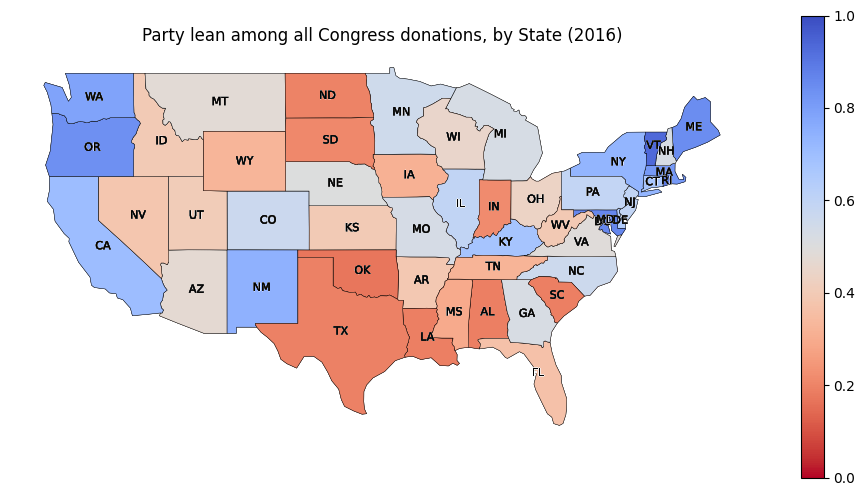

In [51]:
fig, ax = plt.subplots(figsize=(12, 6))
ratio[ratio["level"].isin(["Senate", "House"])].plot(
    column="dem_ratio",
    cmap="coolwarm_r",
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    legend=True,
    missing_kwds={"color": "lightgray"},
    vmin=0,
    vmax=1
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="black")
    text.set_path_effects([path_effects.Stroke(linewidth=0.1, foreground="white"), path_effects.Normal()])

ax.set_title(f'Party lean among all Congress donations, by State (20{year})')
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [52]:
ratio[ratio["level"].isin(["Senate", "House"])][["state", "total", "level"]].sort_values(by="total", ascending=False).head(10)

,state,total,level
51,CA,113000449.0,Senate
48,CA,91146722.0,House
198,NY,74840996.0,Senate
246,TX,63987365.0,Senate
72,FL,61831918.0,House
195,NY,61500347.0,House
75,FL,51442586.0,Senate
243,TX,41449342.0,House
135,MD,35533186.0,Senate
106,IL,31791929.0,Senate


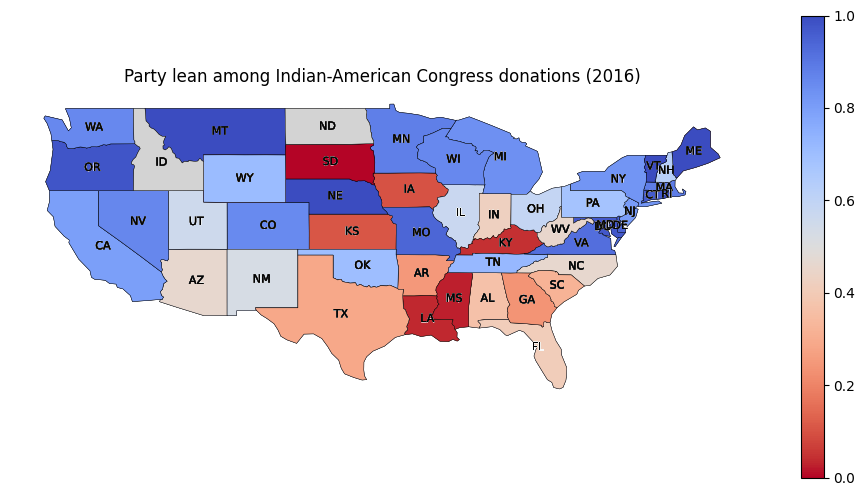

In [53]:
fig, ax = plt.subplots(figsize=(12, 6))
ratio_indian[ratio_indian["level"].isin(["Senate", "House"])].plot(
    column="dem_ratio",
    cmap="coolwarm_r",
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    legend=True,
    missing_kwds={"color": "lightgray"},
    vmin=0,
    vmax=1
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="black")
    text.set_path_effects([path_effects.Stroke(linewidth=0.1, foreground="white"), path_effects.Normal()])

ax.set_title(f'Party lean among Indian-American Congress donations (20{year})')
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [54]:
ratio_indian[ratio_indian["level"].isin(["Senate", "House"])][["state", "total", "level"]].sort_values(by="total", ascending=False).head(10)

,state,total,level
48,CA,2019234.0,House
51,CA,1123790.0,Senate
103,IL,782617.0,House
195,NY,702873.0,House
253,VA,659213.0,House
72,FL,635900.0,House
243,TX,537881.0,House
135,MD,507229.0,Senate
198,NY,391332.0,Senate
106,IL,388185.0,Senate


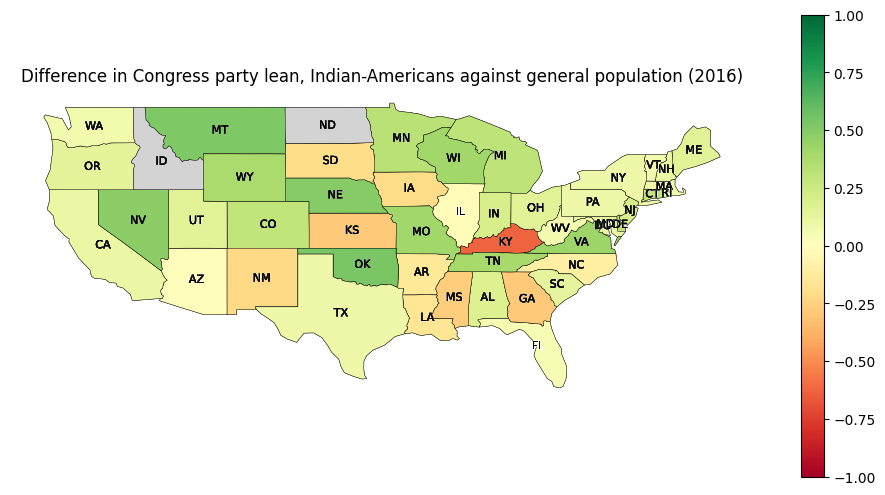

In [55]:
ratio["diff"] = ratio_indian["dem_ratio"] - ratio["dem_ratio"]

fig, ax = plt.subplots(figsize=(12, 6))
ratio[ratio["level"].isin(["Senate", "House"])].plot(
    column="diff",
    cmap="RdYlGn",
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    legend=True,
    missing_kwds={"color": "lightgray"},
    vmin=-1,
    vmax=1
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="black")
    text.set_path_effects([path_effects.Stroke(linewidth=0.1, foreground="white"), path_effects.Normal()])

ax.set_title(f'Difference in Congress party lean, Indian-Americans against general population (20{year})')
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

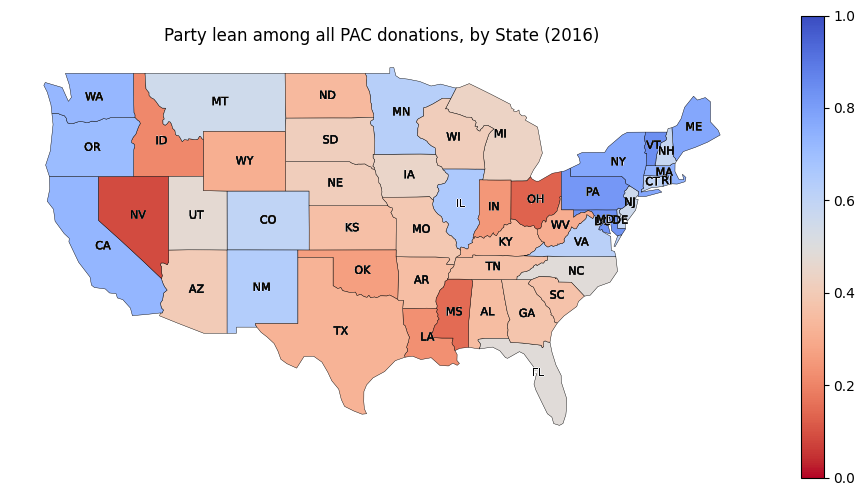

In [56]:
fig, ax = plt.subplots(figsize=(12, 6))
ratio[ratio["level"] == "PAC"].plot(
    column="dem_ratio",
    cmap="coolwarm_r",
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    legend=True,
    missing_kwds={"color": "lightgray"},
    vmin=0,
    vmax=1
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="black")
    text.set_path_effects([path_effects.Stroke(linewidth=0.1, foreground="white"), path_effects.Normal()])

ax.set_title(f'Party lean among all PAC donations, by State (20{year})')
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

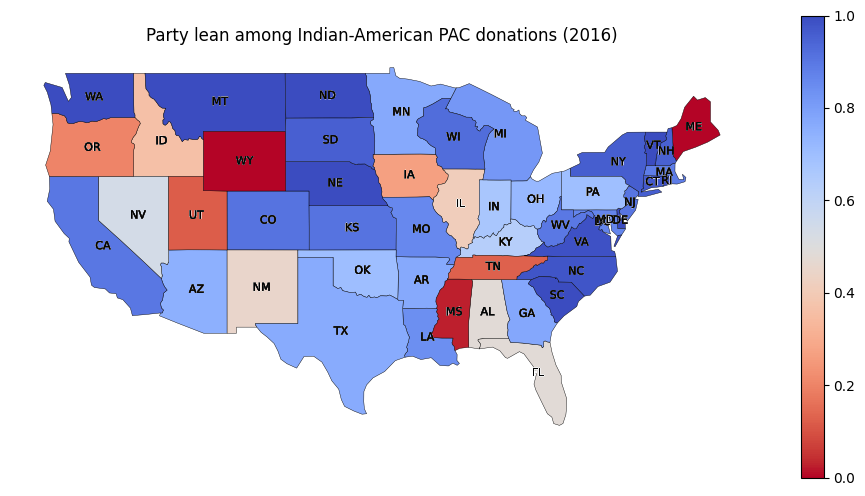

In [58]:
fig, ax = plt.subplots(figsize=(12, 6))
ratio_indian[ratio_indian["level"] == "PAC"].plot(
    column="dem_ratio",
    cmap="coolwarm_r",
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    legend=True,
    missing_kwds={"color": "lightgray"},
    vmin=0,
    vmax=1
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="black")
    text.set_path_effects([path_effects.Stroke(linewidth=0.1, foreground="white"), path_effects.Normal()])

ax.set_title(f'Party lean among Indian-American PAC donations (20{year})')
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

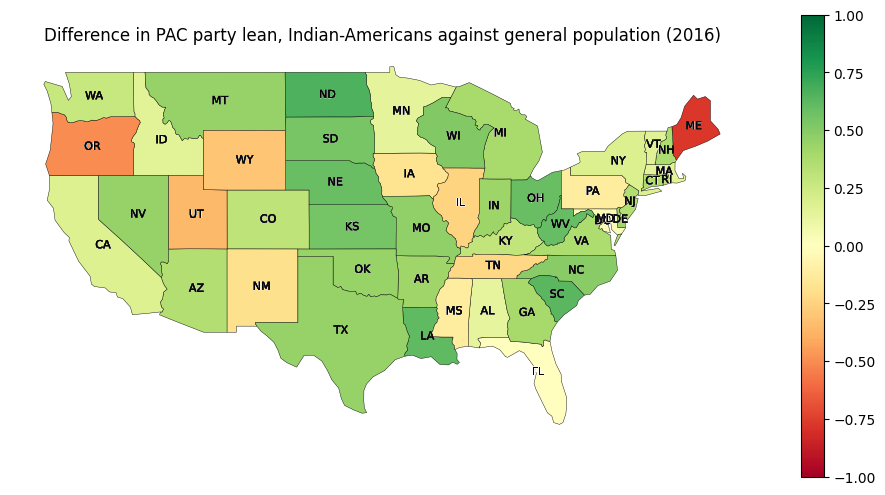

In [59]:
fig, ax = plt.subplots(figsize=(12, 6))
ratio[ratio["level"] == "PAC"].plot(
    column="diff",
    cmap="RdYlGn",
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    legend=True,
    missing_kwds={"color": "lightgray"},
    vmin=-1,
    vmax=1
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="black")
    text.set_path_effects([path_effects.Stroke(linewidth=0.1, foreground="white"), path_effects.Normal()])

ax.set_title(f'Difference in PAC party lean, Indian-Americans against general population (20{year})')
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()